In [1]:
# Import libraries.
import cv2                              # For image processing.
import gym                              # Interface for interacting with the environment.
import imageio                          # Used to generate GIFs.
import matplotlib.pyplot as plt         # Plot images and statistics.
import numpy as np                      # Work with matrices efficiently.
import torch                            # Includes everything we need for the neural network.
import datetime                         # Used to get the current timestamp.
import random                           # Functions for non-deterministic behaviour.
import os                               # Used to create new directories.
import time                             # Gives us the current time.
from skimage.transform import resize    # Resizes images.

In [2]:
# A few checks to see if we can use a GPU and which GPUs are available.
print("Cuda available: {}".format(torch.cuda.is_available()))
for i in range(torch.cuda.device_count()):
    print("Device name: {}".format(torch.cuda.get_device_name(i)))

Cuda available: True
Device name: NVIDIA GeForce GTX 1060 6GB


In [3]:
class ReplayBuffer:
    """The replay buffer stores the observed images, performed actions, rewards and whether the episode terminated.
       We can use it to randomly sample previously observed states/experiences."""
    
    def __init__(self, capacity, image_height, image_width, image_history_length, batch_size, device):
        self.capacity = capacity
        self.image_height = image_height
        self.image_width = image_width
        self.image_history_length = image_history_length
        self.batch_size = batch_size
        self.ptr = 0      # Pointer/current index.
        self.size = 0     # Current size of the buffer.

        # Pre-allocate tensors so we can see beforehand whether we have enough memory or not.
        # Data from environment.
        self.images = torch.empty((capacity, image_height, image_width), dtype=torch.float, device='cpu')
        self.actions = torch.empty(capacity, dtype=torch.int64, device=device)
        self.rewards = torch.empty(capacity, dtype=torch.float, device=device)
        self.done = torch.empty(capacity, dtype=torch.bool, device=device)
        
        # Buffer specific tensors.
        self.states = torch.empty((self.batch_size, self.image_history_length, 
                                   self.image_height, self.image_width), dtype=torch.float, device=device)
        self.next_states = torch.empty((self.batch_size, self.image_history_length, 
                                       self.image_height, self.image_width), dtype=torch.float, device=device)
        self.indices = torch.empty(batch_size, dtype=torch.long, device='cpu')
        
    def put(self, observation, action, reward, done):
        # Add experience to the buffer.
        self.images[self.ptr] = observation
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.done[self.ptr] = done
        
        self.size = min(self.size + 1, self.capacity)
        self.ptr = (self.ptr + 1) % self.capacity
        
    def _get_indices(self):
        # Get valid indices to reference experiences.
        for i in range(self.batch_size):
            while True:
                index = random.randint(self.image_history_length, self.size - 1)
                if index >= self.ptr and index - self.image_history_length <= self.ptr:
                    # We can not create a stack of images.
                    continue
                if self.done[index - self.image_history_length:index].any():
                    # Stack contains experiences from two different episodes.
                    continue
                break
            self.indices[i] = index
        
    def get(self):
        self._get_indices()
        
        # Create stacked batches of images.
        for i, batch_idx in enumerate(self.indices):
            self.states[i] = self.images[batch_idx-self.image_history_length:batch_idx, ...]
            self.next_states[i] = self.images[batch_idx-self.image_history_length+1:batch_idx+1, ...]
        return (self.states,
                self.actions[self.indices],
                self.rewards[self.indices],
                self.next_states,
                self.done[self.indices])

In [4]:
class EpsilonSchedule:
    """Calculates the exploration probability (epsilon) for a given timestep."""
    
    def __init__(self, start_learning, eps_final, eps_start, frame_decay):
        self.eps_start = eps_start
        self.start_learning = start_learning
        self.eps_final = eps_final
        self.frame_decay = frame_decay
    
    def get_epsilon(self, timestep, evaluation=False):
        if evaluation:
            # No exploration during evaluation -> we want to measure model performance.
            return 0.0
        if timestep < self.start_learning:
            return self.eps_start
        else:
            eps = self.eps_start - ((timestep - self.start_learning) / self.frame_decay) * (self.eps_start - self.eps_final)
            return max(self.eps_final, eps)

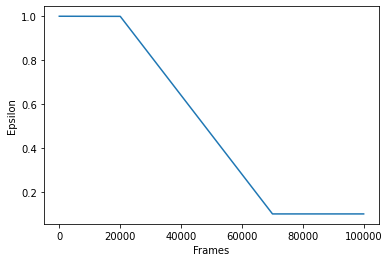

In [5]:
es = EpsilonSchedule(20000, 0.1, 1.0, 50000)
x = []
y = []
for t in range(100000):
    x.append(t)
    y.append(es.get_epsilon(t))
plt.xlabel('Frames')
plt.ylabel('Epsilon')
plt.plot(x, y)
plt.show()

In [6]:
def preprocess(image, image_height, image_width):
    """Improve computation speed by preprocessing the image. Transforms to gray scale, crops, resizes and normalizes
       the image."""
    gray = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]
    gray = gray[34:194, 0:160]
    gray = cv2.resize(gray, dsize=(image_height, image_width), interpolation=cv2.INTER_NEAREST)
    return gray / 255

Original shape: (210, 160, 3)
Shape after preprocessing: (84, 84)
Possible actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


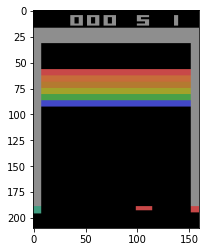

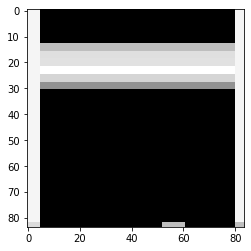

In [7]:
env = gym.make('BreakoutDeterministic-v4')
print("Original shape:", env.reset().shape)

test_image = preprocess(env.reset(), 84, 84)
print("Shape after preprocessing:", test_image.shape)

print("Possible actions:", env.unwrapped.get_action_meanings())

plt.imshow(env.reset())
plt.show()
plt.imshow(test_image, interpolation='nearest', cmap="gray")
plt.show()

In [8]:
class BreakoutWrapper:
    
    def __init__(self, image_height, image_width, image_history_length, noop_max):
        self.environment = gym.make('BreakoutDeterministic-v4')
        self.action_space = self.environment.action_space.n
        self.previous_lives = 0
        self.image_height = image_height
        self.image_width = image_width
        self.image_history_length = image_history_length
        self.state = None
        self.noop_max = noop_max
    
    def reset(self, evaluation=False):
        observation = self.environment.reset()
        self.previous_lives = 0
        if evaluation:
            for _ in range(random.randint(1, self.noop_max)):
                observation, _, _, _ = self.environment.step(1)
                
        observation_preprocessed = preprocess(observation, self.image_height, self.image_width)
        self.state = torch.FloatTensor(observation_preprocessed).repeat(self.image_history_length, 1, 1)
        return True
        
    
    def step(self, action):
        observation, reward, done, info = self.environment.step(action)
        
        if info["lives"] < self.previous_lives:
            live_lost = True
        else:
            live_lost = done
        self.previous_lives = info["lives"]
        
        observation_processed = torch.FloatTensor(preprocess(observation, self.image_height, self.image_width)).unsqueeze(0)
        self.state = torch.cat([self.state[1:,:,:], observation_processed], 0)
        return observation_processed, reward, done, live_lost, observation

In [9]:
class DQNNetwork(torch.nn.Module):

    def __init__(self, num_actions, image_history_length, device):
        super(DQNNetwork, self).__init__()
        self.device = device

        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=image_history_length, out_channels=32,
                            kernel_size=(8, 8), stride=4, padding="valid"),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64,
                            kernel_size=(4, 4), stride=2, padding="valid"),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64,
                            kernel_size=(3, 3), stride=1, padding="valid"),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=3136, out_features=512),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=512, out_features=num_actions)
        )

    def forward(self, x):
        x = x.to(self.device)
        return self.layers(x)  

In [10]:
def clip_reward(reward):
    if reward > 0:
        return 1
    elif reward == 0:
        return 0
    else:
        return -1

In [11]:
def generate_gif(frame_number, frames_for_gif, reward, path):
    """
        Args:
            frame_number: Integer, determining the number of the current frame
            frames_for_gif: A sequence of (210, 160, 3) frames of an Atari game in RGB
            reward: Integer, Total reward of the episode that es ouputted as a gif
            path: String, path where gif is saved
    """
    for idx, frame_idx in enumerate(frames_for_gif): 
        frames_for_gif[idx] = resize(frame_idx, (420, 320, 3), 
                                     preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave(f'{path}{"ATARI_frame_{0}_reward_{1}.gif".format(frame_number, reward)}', 
                    frames_for_gif, duration=1/30)

In [12]:
class DQN:
    
    def __init__(self, environment, scheduler, buffer, image_height, image_width, image_history_length, learning_rate,
                 discount, device):
        self.environment = environment
        self.scheduler = scheduler
        self.replay_buffer = buffer
        self.learning_rate = learning_rate
        self.discount = discount
        self.device = device        

        self.net = DQNNetwork(self.environment.action_space, image_history_length, self.device).to(self.device)
        self.target_net = DQNNetwork(self.environment.action_space, image_history_length, self.device).to(self.device)
        self.target_net.load_state_dict(self.net.state_dict())
        self.target_net.eval()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learning_rate)
        self.loss = torch.nn.HuberLoss()
        
    def _get_action(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                q_value = self.net(torch.unsqueeze(state, 0))
                return q_value.argmax().item()
        else:
            return random.choice([0,2,3])
    
    def _backpropagation(self):
        observations, actions, rewards, next_observations, dones = self.replay_buffer.get()

        future_rewards = self.target_net(next_observations)
        updated_q_values = rewards + self.discount * future_rewards.max(1)[0] * ~(dones)

        q_values = self.net(observations)
        q_values = q_values.gather(1, actions.unsqueeze(1))

        loss = self.loss(q_values.squeeze(1), updated_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def learn(self, max_images, update_after, max_episode_length, sync_target, evaluate_after):
        number_observations = 0
        rewards = []
        loss_list = []
        print("Timestamp/Episode/Number Observations/Mean of last 100 rewards/Loss")
        while number_observations < max_images:
            epoch_frame = 0
            while epoch_frame < evaluate_after:
                life_lost = self.environment.reset()
                episode_reward = 0
                for _ in range(max_episode_length):
                    if life_lost:
                        action = 1
                    else:
                        epsilon = self.scheduler.get_epsilon(number_observations)
                        action = self._get_action(self.environment.state, epsilon)

                    next_observation, reward, done, life_lost, _ = self.environment.step(action)
                    number_observations += 1
                    epoch_frame += 1
                    episode_reward += reward
                    reward = clip_reward(reward)
                    self.replay_buffer.put(next_observation, action, reward, life_lost)

                    if number_observations % update_after == 0 and number_observations > self.scheduler.start_learning:
                        loss = self._backpropagation()
                        loss_list.append(loss)
                        
                    if number_observations % sync_target == 0 and number_observations > self.scheduler.start_learning:
                        self.target_net.load_state_dict(self.net.state_dict())
                    
                    if done:
                        rewards.append(episode_reward)
                        if len(rewards) % 10 == 0:
                            timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%d.%m.%Y %H:%M:%S')
                            print(str(timestamp), len(rewards), number_observations, np.mean(rewards[-100:]),
                                  np.mean(loss_list))
                            with open('output\\data.txt', 'a') as file:
                                print(str(timestamp), len(rewards), number_observations, 
                                np.mean(rewards[-100:]), np.mean(loss_list), file=file)
                            loss_list = []
                        break
                        
            # Evaluation:
            terminal = True
            gif = True
            frames_for_gif = []
            eval_rewards = []
            evaluate_frame_number = 0
            
            for _ in range(10000):
                if terminal:
                    terminal_life_lost = environment.reset(evaluation=True)
                    episode_reward_sum = 0
                    terminal = False
               
                # Fire (action 1), when a life was lost or the game just started, 
                # so that the agent does not stand around doing nothing.
                if terminal_life_lost:
                    action = 1
                else:
                    epsilon = self.scheduler.get_epsilon(number_observations, True)
                    action = self._get_action(self.environment.state, epsilon)

                processed_new_frame, reward, terminal, terminal_life_lost, new_frame = environment.step(action)
                evaluate_frame_number += 1
                episode_reward_sum += reward

                if gif: 
                    frames_for_gif.append(new_frame)
                if terminal:
                    eval_rewards.append(episode_reward_sum)
                    gif = False # Save only the first game of the evaluation as a gif
                     
            timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%d.%m.%Y %H:%M:%S')
            print("Evaluation score:", str(timestamp), str(number_observations), np.mean(eval_rewards))
            try:
                generate_gif(number_observations, frames_for_gif, eval_rewards[0], "output\\")
            except IndexError:
                print("No evaluation game finished")
            
            # Save the network parameters
            torch.save(self.net.state_dict(), "model\\model_{}.pt".format(str(number_observations)))
            with open('output\\dataEval.txt', 'a') as eval_file:
                print(str(timestamp), number_observations, np.mean(eval_rewards), file=eval_file)
            frames_for_gif = []

In [17]:
# Use CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

# Environment hyperparameters:
image_height = 84
image_width = 84
image_history_length = 4
noop_max = 10
environment = BreakoutWrapper(image_height, image_width, image_history_length, noop_max)

# Scheduler hyperparameters:
start_learning = 60000
epsilon_start = 1.0
epsilon_final = 0.1
frame_decay = 3000000
scheduler = EpsilonSchedule(start_learning, epsilon_final, epsilon_start, frame_decay)

# Buffer hyperparameters:
capacity = 300000
batch_size = 32
buffer = ReplayBuffer(capacity, image_height, image_width, image_history_length, batch_size, device)

# DQN hyperparameters:
learning_rate = 0.00001
sync_target = 10000
max_images = 30000000
max_episode_length = 18000
update_after = 4
discount = 0.99
evaluate_after = 200000
dqn = DQN(environment, scheduler, buffer, image_height, image_width,
          image_history_length, learning_rate, discount, device)

Device: cuda


In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()
del buffer
del environment
del scheduler
del dqn

In [18]:
if not os.path.exists("model"):
    os.mkdir("model")
if not os.path.exists("output"):
    os.mkdir("output")
if os.path.exists(os.path.join("output", "data.txt")):
    os.remove(os.path.join("output", "data.txt"))
if os.path.exists(os.path.join("output", "dataEval.txt")):
    os.remove(os.path.join("output", "dataEval.txt"))

In [ ]:
dqn.learn(max_images, update_after, max_episode_length, sync_target, evaluate_after)

Timestamp/Episode/Number Observations/Mean of last 100 rewards/Loss
10.02.2022 03:11:43 10 1463 0.5 nan
10.02.2022 03:11:45 20 3030 0.65 nan
10.02.2022 03:11:46 30 4622 0.7 nan
10.02.2022 03:11:48 40 6133 0.675 nan
10.02.2022 03:11:50 50 8132 0.88 nan
10.02.2022 03:11:51 60 9740 0.8666666666666667 nan
10.02.2022 03:11:53 70 11565 0.9428571428571428 nan
10.02.2022 03:11:55 80 13219 0.9625 nan
10.02.2022 03:11:57 90 14897 0.9666666666666667 nan
10.02.2022 03:11:58 100 16464 0.95 nan
10.02.2022 03:12:00 110 18087 0.98 nan
10.02.2022 03:12:01 120 19750 1.0 nan
10.02.2022 03:12:03 130 21319 1.0 nan
10.02.2022 03:12:04 140 22799 0.99 nan
10.02.2022 03:12:06 150 24378 0.91 nan
10.02.2022 03:12:07 160 25831 0.87 nan
10.02.2022 03:12:09 170 27447 0.82 nan
10.02.2022 03:12:11 180 28981 0.78 nan
10.02.2022 03:12:12 190 30643 0.79 nan
10.02.2022 03:12:14 200 32153 0.77 nan
10.02.2022 03:12:16 210 33919 0.83 nan
10.02.2022 03:12:17 220 35438 0.8 nan
10.02.2022 03:12:19 230 36948 0.78 nan
10.02.2022

10.02.2022 03:27:49 1530 244022 1.13 0.0020925693800917973
10.02.2022 03:27:57 1540 245598 1.09 0.002126183846716055
10.02.2022 03:28:05 1550 247257 1.01 0.0019416110589398992
10.02.2022 03:28:12 1560 248797 1.0 0.0018740290683669993
10.02.2022 03:28:21 1570 250480 1.0 0.002038582061589397
10.02.2022 03:28:29 1580 252170 1.02 0.002268652246354073
10.02.2022 03:28:37 1590 253774 1.01 0.0020878553325037455
10.02.2022 03:28:45 1600 255519 1.07 0.002093789305077618
10.02.2022 03:28:53 1610 257046 0.98 0.002191998296053422
10.02.2022 03:29:01 1620 258785 1.02 0.0019138237577193983
10.02.2022 03:29:10 1630 260535 0.97 0.0020146196761628874
10.02.2022 03:29:18 1640 262324 1.03 0.0027359501105560674
10.02.2022 03:29:26 1650 263780 0.99 0.002223870891612023
10.02.2022 03:29:33 1660 265259 0.96 0.0021915550176956535
10.02.2022 03:29:41 1670 266955 0.97 0.00216145306413242
10.02.2022 03:29:50 1680 268662 0.97 0.00169159352431233
10.02.2022 03:29:57 1690 270284 0.98 0.0020854984103083228
10.02.202

10.02.2022 03:49:03 2940 502346 1.55 0.006261427207466434
10.02.2022 03:49:14 2950 504449 1.59 0.006038335750646139
10.02.2022 03:49:22 2960 506094 1.5 0.006039156089026998
10.02.2022 03:49:31 2970 508021 1.48 0.006012260238301875
10.02.2022 03:49:39 2980 509702 1.47 0.0055781282420780155
10.02.2022 03:49:50 2990 511912 1.51 0.006483896747888293
10.02.2022 03:49:59 3000 513852 1.51 0.005885909820460359
10.02.2022 03:50:10 3010 516014 1.57 0.005931503246797041
10.02.2022 03:50:19 3020 517771 1.64 0.0057244560785235194
10.02.2022 03:50:28 3030 519676 1.62 0.005387842380983532
10.02.2022 03:50:39 3040 521821 1.74 0.00641388711979988
10.02.2022 03:50:47 3050 523580 1.69 0.007074877988039093
10.02.2022 03:50:58 3060 525689 1.82 0.005941697710681445
10.02.2022 03:51:08 3070 527795 1.86 0.006193990838521837
10.02.2022 03:51:17 3080 529663 1.91 0.006067102953215275
10.02.2022 03:51:28 3090 531787 1.91 0.00711995445340065
10.02.2022 03:51:38 3100 533856 1.94 0.00661698158814223
10.02.2022 03:51

10.02.2022 04:12:17 4350 781501 2.04 0.009180497186989134
10.02.2022 04:12:26 4360 783419 2.02 0.008884676173620999
10.02.2022 04:12:39 4370 785906 2.16 0.009296709560254631
10.02.2022 04:12:47 4380 787592 2.05 0.009356863132150518
10.02.2022 04:12:58 4390 789781 2.08 0.009377134491824009
10.02.2022 04:13:08 4400 791905 1.93 0.009395601714806887
10.02.2022 04:13:19 4410 794151 1.95 0.008688908976539239
10.02.2022 04:13:31 4420 796537 1.96 0.009072745279128191
10.02.2022 04:13:41 4430 798558 2.07 0.010224703596536034
Evaluation score: 10.02.2022 04:14:09 800313 19.055555555555557
10.02.2022 04:14:14 4440 800471 2.05 0.008828325804506106
10.02.2022 04:14:25 4450 802616 2.16 0.010179170691347517
10.02.2022 04:14:36 4460 804744 2.23 0.008779061326224889
10.02.2022 04:14:47 4470 807083 2.19 0.008489014088074127
10.02.2022 04:14:57 4480 808969 2.27 0.008763165726924267
10.02.2022 04:15:08 4490 811255 2.31 0.011234996367152944
10.02.2022 04:15:18 4500 813354 2.29 0.009940115127579443
10.02.20

10.02.2022 04:39:12 5750 1096546 3.64 0.013000366635296894
10.02.2022 04:39:29 5760 1099913 3.94 0.012829212399670796
10.02.2022 04:39:41 5770 1102213 3.9 0.013969003878047932
10.02.2022 04:39:54 5780 1104813 4.04 0.014085160140664531
10.02.2022 04:40:06 5790 1107261 3.87 0.014629160000005238
10.02.2022 04:40:19 5800 1109800 3.84 0.01361101944417524
10.02.2022 04:40:33 5810 1112531 3.96 0.013020896670323882
10.02.2022 04:40:45 5820 1115015 3.92 0.013505316275695336
10.02.2022 04:41:00 5830 1117873 3.92 0.01357103677277642
10.02.2022 04:41:15 5840 1120910 4.06 0.013346051193567604
10.02.2022 04:41:30 5850 1123887 4.1 0.014041053410525615
10.02.2022 04:41:46 5860 1127091 4.09 0.01322918639346241
10.02.2022 04:42:02 5870 1130189 4.31 0.014172797136669678
10.02.2022 04:42:13 5880 1132473 4.19 0.0180240323205989
10.02.2022 04:42:25 5890 1134776 4.14 0.01663441481489119
10.02.2022 04:42:37 5900 1137301 4.12 0.016256207100258883
10.02.2022 04:42:50 5910 1139831 3.97 0.015546627786994876
10.02

10.02.2022 05:12:29 7140 1479902 5.43 0.015917709834133976
10.02.2022 05:12:44 7150 1482790 5.48 0.01825847527575924
10.02.2022 05:13:01 7160 1486023 5.46 0.016329538743334388
10.02.2022 05:13:19 7170 1489555 5.59 0.01680555500882221
10.02.2022 05:13:37 7180 1493060 5.79 0.01887523789015071
10.02.2022 05:13:52 7190 1495974 5.82 0.018632027769274497
10.02.2022 05:14:07 7200 1498980 5.77 0.01804899936201338
10.02.2022 05:14:25 7210 1502378 5.95 0.01833596434449674
10.02.2022 05:14:45 7220 1506307 6.24 0.015445592861087678
10.02.2022 05:15:01 7230 1509426 5.91 0.015677704340599192
10.02.2022 05:15:16 7240 1512363 5.73 0.017741529136827618
10.02.2022 05:15:37 7250 1516457 6.03 0.017186313266392972
10.02.2022 05:15:51 7260 1519217 5.88 0.017891162177007914
10.02.2022 05:16:08 7270 1522383 5.67 0.016634232634219297
10.02.2022 05:16:23 7280 1525394 5.51 0.018469725231482964
10.02.2022 05:16:39 7290 1528393 5.55 0.016682534435453516
10.02.2022 05:16:53 7300 1531057 5.48 0.01786789278305407
10.

10.02.2022 05:57:32 8520 1988591 8.18 0.017916964526757558
10.02.2022 05:57:57 8530 1993319 8.65 0.01912428260987306
10.02.2022 05:58:19 8540 1997514 8.94 0.019413944454091264
Evaluation score: 10.02.2022 05:58:58 2001309 25.923076923076923
10.02.2022 05:59:09 8550 2002113 9.15 0.019678297727874924
10.02.2022 05:59:36 8560 2007071 9.13 0.01953756885886451
10.02.2022 05:59:59 8570 2011419 9.56 0.019921212330102415
10.02.2022 06:00:25 8580 2016299 9.79 0.019614479575901612
10.02.2022 06:00:48 8590 2020551 9.94 0.021123136723368505
10.02.2022 06:01:08 8600 2024228 9.88 0.02283737839391941
10.02.2022 06:01:29 8610 2028291 9.97 0.022096118266038193
10.02.2022 06:01:56 8620 2033246 10.21 0.021855514728831755
10.02.2022 06:02:18 8630 2037341 10.0 0.020016111632230604
10.02.2022 06:02:44 8640 2042226 10.28 0.02166004264273396
10.02.2022 06:03:07 8650 2046565 10.21 0.021032686472960537
10.02.2022 06:03:34 8660 2051593 10.25 0.01932468898401743
10.02.2022 06:03:55 8670 2055565 10.04 0.0205761236

10.02.2022 07:05:58 9870 2729782 25.29 0.016518747523859012
10.02.2022 07:06:37 9880 2737044 25.17 0.0169037928852706
10.02.2022 07:07:15 9890 2743936 25.14 0.01769768405050035
10.02.2022 07:07:56 9900 2751521 25.19 0.018750276432872675
10.02.2022 07:08:27 9910 2757079 24.09 0.017192135015844528
10.02.2022 07:09:09 9920 2764857 24.08 0.018848418552730145
10.02.2022 07:09:50 9930 2772417 24.01 0.01865543819453922
10.02.2022 07:10:35 9940 2780540 24.13 0.017957799287044256
10.02.2022 07:11:17 9950 2788292 23.85 0.018458613641564883
10.02.2022 07:12:07 9960 2797523 24.53 0.01608123162393565
Evaluation score: 10.02.2022 07:12:57 2803163 53.142857142857146
10.02.2022 07:13:26 9970 2806074 24.76 0.016630087462075272
10.02.2022 07:14:09 9980 2813750 25.18 0.01584358414605458
10.02.2022 07:14:49 9990 2820937 25.25 0.0157704597275417
10.02.2022 07:15:33 10000 2829011 25.73 0.01577920706403175
10.02.2022 07:16:22 10010 2837829 26.92 0.016504242530413597
10.02.2022 07:17:14 10020 2847146 27.59 0.

10.02.2022 09:12:05 11160 4049774 51.11 0.008192780521470341
10.02.2022 09:13:11 11170 4061537 51.2 0.010748008909997515
10.02.2022 09:14:24 11180 4074744 52.16 0.010679723287678449
10.02.2022 09:15:34 11190 4087196 52.93 0.011563402168357603
10.02.2022 09:16:37 11200 4098505 53.29 0.02043470591968034
10.02.2022 09:17:40 11210 4109811 53.1 0.026010554850197702
10.02.2022 09:18:33 11220 4119381 51.52 0.07247854705315786
10.02.2022 09:19:30 11230 4129645 50.03 0.12322055267658054
10.02.2022 09:20:19 11240 4138491 48.81 0.3106319689631423
10.02.2022 09:21:02 11250 4146104 45.94 0.4965314593073421
10.02.2022 09:21:39 11260 4152752 43.33 0.6996127956825063
10.02.2022 09:22:19 11270 4160051 40.45 0.7463806369635502
10.02.2022 09:22:55 11280 4166431 36.44 0.9899795463031339
10.02.2022 09:23:26 11290 4172138 31.9 1.0391014510985612
10.02.2022 09:23:55 11300 4177202 28.13 1.6171201294432225
10.02.2022 09:24:20 11310 4181844 24.38 2.0162716915397394
10.02.2022 09:24:41 11320 4185458 21.5 2.65896

10.02.2022 10:52:17 12490 5102460 52.2 0.006070334447174877
10.02.2022 10:53:21 12500 5113839 51.95 0.004856601676271813
10.02.2022 10:54:24 12510 5125272 51.89 0.0051559953039545265
10.02.2022 10:55:32 12520 5137297 50.7 0.005068964179604781
10.02.2022 10:56:37 12530 5149053 50.95 0.005295316088854678
10.02.2022 10:57:40 12540 5160273 51.57 0.004969425157788285
10.02.2022 10:58:45 12550 5171895 51.27 0.005297214720977659
10.02.2022 10:59:50 12560 5183640 50.27 0.005916326870980229
10.02.2022 11:00:52 12570 5194731 49.34 0.005215424445044844
10.02.2022 11:01:53 12580 5205728 49.26 0.005354073419722475
Evaluation score: 10.02.2022 11:02:29 5208787 70.0
10.02.2022 11:03:27 12590 5216658 49.3 0.005866212096587021
10.02.2022 11:04:36 12600 5229005 50.45 0.006003596415123406
10.02.2022 11:05:42 12610 5240833 51.01 0.0057143672066827305
10.02.2022 11:06:48 12620 5252683 51.35 0.005677286887164576
10.02.2022 11:07:50 12630 5263787 51.22 0.005475880597010678
10.02.2022 11:08:52 12640 5274901 5